**En résumé :**

**- J'utilise de nouveau les données Fashion-MNIST**

**- lorsqu'on leurre le classifieur, les résultats de classification sont plus dégradés qu'ils l'étaient avec MNIST**

**- le modèle convolutif avait un taux d'erreur moitié moindre que ses "cousins" non convolutifs, sur les données MNIST. Ce n'est plus du tout le cas avec les données Fashion-MNIST**

**- sur le jeu de données Fashion-MNIST, la randomisation n'est pas du tout "rentable", car il faut un temps de calcul énorme, pour un gain final de 0,001 sur le taux d'erreur.**

**Cela aurait été utile de le savoir avant, ce qui pose la question de "peut-on le déterminer avant ?" et de "comment le déterminer avant ?" si la réponse à la première question est "oui". En effet, ne pouvoir constater l'apport (ou sa faiblesse) de la randomisation sur un jeu de données, qu'une fois le temps de calcul écoulé, est dommage !**

**- je n'ai pu traiter les dernières parties car elles nécessitaient l'usage d'un solver que je ne parviens pas à charger (gurabi).**

**J'ai rectifié une erreur visible dans le début du texte.**

**J'ai traduit le texte en français car lire en anglais sur cette longueur, avec en plus la nécessité de me concentrer pour comprendre les notions mathématiques, était très fatiguant.**
**Lorsque mes résultats sur Fashion-MINST diffèrent des résultats d'origine, j'ai mis mes commentaires en gras.**


In [ ]:
### PREAMBLE
# Chapter 3 - Adversarial examples, solving the inner maximization
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Cas des réseaux de neurones

La nature des réseaux de neurones rend le problème des exemples adverses  beaucoup plus prononcé (un réseau de neurones typiquement entraîné est beaucoup plus sensible aux attaques adversariales que même les modèles linéaires naïfs que nous avons considérés), et le modèle beaucoup plus difficile à protéger.

Le problème de maximisation interne devient :

\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x), y)
\end{equation}

<span style="color: red;">**Sauf que je pense qu'il y a une erreur dans l'équation, qui devrait plutôt être, si on a bien lu les chapitres précédents :**

\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x+\delta), y)
\end{equation}</span>

où $h_\theta$ représente maintenant un réseau de neurones.  


Forme précise de $h_\theta$ :

$h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ comme un réseau à $d$ couches, donné par les équations suivantes :


\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}

où $z_i$​ désignent les activations à la couche $i$;

$f_i$​ désigne la fonction d'activation de la couche $i$, que nous prendrons souvent par exemple comme étant l'opérateur ReLU $f_i(z) = \max\{0,z\}$ pour les couches $i=1,\ldots,d-1$,

et l'opérateur linéaire $f_i(z) = z$ pour la couche $d$.

Les sorties de la dernière couche sont les logits de classe, et la fonction de perte "intègre" l'opérateur softmax, donc nous ne mettons pas explicitement le softmax dans le réseau.

Les paramètres du réseau sont donnés par $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (dans ce qui précède, $W_i$​ est  interprété comme une matrice, mais il pourrait en réalité être n'importe quel opérateur linéaire, y compris des convolutions).

Nous ne définissons pas pour l'instant explicitement la taille de toutes les couches intermédiaires, mais nous supposons qu'elles sont spécifiées de manière à ce que la fonction finale $h_\theta$​ prenne des entrées dans $\mathbb{R}^n$ et produise des vecteurs dans $\mathbb{R}^k$.

La fonction de perte est la même que celle que nous avons utilisée précédemment pour le cas multiclasses, à savoir la perte d'entropie croisée :

\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

Le caractère très "irrégulier" de la surface de la perte pour un réseau de neurone "standard" génère des défis absents pour le cas du modèle linéaire...

Exemple pour le modèle simple ci-dessous :

Text(0, 0.5, 'Output')

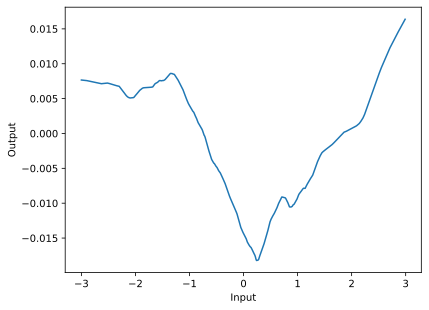

In [ ]:
#créer et entraîner un modèle de réseau de neurones simple à 4 couches entièrement connectées.
#Ce modèle minimise une erreur quadratique moyenne (MSE) entre ses sorties et des cibles générées aléatoirement.
torch.manual_seed(0)
#nn.Sequential() : crée un modèle de réseau de neurones séquentiel
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), #couche n°1, entièrement connectée, avec input de taille 1 et sortie de taille 100
                      nn.Linear(100,100), nn.ReLU(), #couche n°2, entièrement connectée, de 100 neurones
                      nn.Linear(100,100), nn.ReLU(), #idem
                      nn.Linear(100,1)) #dernière couche, composée d'un seul neurone (100 input, 1 sortie)
#après chacune des 3 premières couches, on applique la fonction d'activation ReLU
#Cette fonction d'activation ReLU (Rectified Linear Unit) introduit de la non-linéarité dans le modèle
#en renvoyant 0 pour toute valeur inférieure à 0 et en laissant les valeurs positives inchangées.

opt = optim.SGD(model.parameters(),lr=1e-2) #on utilise la descente de gradient stochastique pour ajuster les poids du modèle durant l'apprentissage

#boucle d'entrainement du modèle
for _ in range(100): #on fait 100 itérations d'entrainement
#torch.randn(100,1) : génère un batch de données aléatoires de taille (100,1) (suivant une distribution normale)
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))#MSELoss mesure la différence quadratique (carré des différences) entre
    #la sortie du modèles model(torch.randn(100,1), et une cible aléatoire torch.randn(100,1))
    opt.zero_grad() #réinitialise les gradients accumulés dans le modèle
    loss.backward() #calcule les gradients de la perte par rapport aux paramètres, par rétropropagation
    opt.step() #applique les nouveaux gradients calculés pour mettre à jour les paramètres du modèle

#représentation graphique
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
#np.arange(-3, 3, 0.01) : génère une séquence de valeurs d'entrée allant de -3 à 3 avec un pas de 0.01
#model(torch.arange(-3,3,0.01)[:,None]) : passe cette séquence d'entrées au modèle
#on trace la sortie avec plt.plot(). La méthode detach().numpy() permet d'obtenir les valeurs de sortie sous forme de tableau NumPy,
#en évitant la dépendance à la computation des gradients.
plt.xlabel("Input")
plt.ylabel("Output")

# Ces surfaces de perte entraînent deux principaux défis.

- Dans le cadre de hautes dimensions que nous considérons généralement avec les réseaux profonds, il y a une forte probabilité qu'à presque chaque point de l'espace d'entrée, il existe une direction le long de la surface de perte qui est très raide, c'est-à-dire qui provoque une augmentation ou une diminution substantielle de la perte.

  Cela correspond en fait à l'équivalent mathématique de ce que nous avons vu dans le chapitre introductif : nous pouvons déplacer légèrement un point dans l'espace d'entrée (c'est-à-dire appliquer une petite perturbation), ce qui entraîne une grande augmentation de la perte.

  En d'autres termes, les réseaux de neurones, en raison de la nature de leurs surfaces de perte, sont particulièrement vulnérables aux exemples adverses.

- Contrairement au cas linéaire, il n'est pas facile de résoudre (ou de majorer facilement, comme pour le cas linéaire multiclasses), le problème de maximisation interne de notre perturbation.

  En effet, la surface de coût pour les réseaux de neurones (en considérant l'espace d'entrée, et non l'espace des paramètres) n'est pas convexe et est particulièrement sujette aux optima locaux.

  Même dans l'exemple simple ci-dessus, il existe des optima locaux lorsque nous essayons de maximiser ou de minimiser, et le gradient initial à un point donné peut ou non pointer dans la direction du maximum réel.

 Ce second point est un peu moins problématique si notre objectif est simplement de construire un exemple adverse contre un réseau profond standard (comme le premier point l'illustre, il existe de nombreuses directions où le coût augmente fortement, et suivre simplement le gradient conduit généralement à un exemple adverse, même s'il n'est pas optimal).

 Mais lorsque nous considérons l'entraînement de réseaux robustes, cela deviendra un problème majeur, car cela signifie que le théorème de Danskin ne s'applique plus, et nous ne pouvons donc pas résoudre le véritable problème d'optimisation robuste.


### Stratégies pour la maximisation interne

Alors, comment résoudre (approximativement) le problème d'optimisation interne :

\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x), y)
\end{equation}

dans le cas où $h_\theta$​ est un réseau de neurones ? Il existe trois stratégies principales pour résoudre ce problème, qui se rapportent à des bornes inférieures, des solutions exactes et des bornes supérieures sur cet objectif d'optimisation. Plus en détail, nous avons les options suivantes :


1. Trouver une borne inférieure sur l'objectif d'optimisation : cela revient à "essayer de résoudre empiriquement le problème d'optimisation", c'est-à-dire à "trouver un exemple adverse". C'est de loin la stratégie la plus courante pour résoudre la maximisation interne (motivée par le fait que pour les réseaux de neurones en général, les problèmes d'optima locaux ne semblent pas aussi graves qu'on pourrait initialement le penser).
Cependant, pour trouver des exemples adverses forts et  utiliser cette approche pour entraîner des classificateurs robustes, il est important de _bien_ résoudre ce problème.

2. Tenter de résoudre le problème d'optimisation de manière exacte :  ce sera un problème difficile, mais pour de nombreuses fonctions d'activation de réseaux, nous pouvons formuler exactement le problème de maximisation comme un problème d'optimisation combinatoire, et le résoudre exactement en utilisant des techniques telles que la programmation linéaire en nombres entiers. Pour de petits problèmes, elles soulignent un point important : il est parfois possible de construire des solutions exactes au problème de maximisation interne.

3. Enfin, nous pouvons aussi majorer l'objectif d'optimisation, comme nous l'avons fait dans le cas linéaire multiclasses. Cela est beaucoup plus complexe que dans le cas linéaire, mais reste possible. Les méthodes employées pour cela ne construisent pas typiquement un véritable exemple adverse pour le réseau réel (car elles opèrent sur un modèle relâché qui n'est pas équivalent à l'original), mais elles peuvent nous assurer, en revanche, qu'un réseau est robuste contre une attaque adverse. Lorsqu'elles sont combinées avec une optimisation robuste pour l'entraînement, ces méthodes constituent l'état de l'art pour l'entraînement de modèles robustes.




### Quelques exemples de réseaux de neurones

Avant de discuter des attaques réelles, entraînons quelques réseaux simples sur le problème MNIST.

Nous allons en fait considérer trois architectures différentes ici : un réseau entièrement connecté à deux ou quatre couches, et un réseau avec quatre couches convolutionnelles plus une couche entièrement connectée.

In [ ]:
#commande qui permet de déterminer et d'attribuer le dispositif (device) sur lequel les opérations de calcul de PyTorch seront effectuées
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#définition de nos trois modèles de réseaux de neurones
class Flatten(nn.Module): #Flatten est une classe personnalisée qui hérite de nn.Module (la classe de base pour définir un modèle en PyTorch)
    def forward(self, x): #définit la façon dont les données passent à travers cette couche
        return x.view(x.shape[0], -1) #aplatit" l'entrée en un vecteur unidimensionnel. La fonction view permet de redimensionner le tensor x.
                                      #L'argument x.shape[0] conserve la première dimension (la taille du lot, i.e., le nombre d'exemples dans un batch),
                                      #et -1 indique que PyTorch doit déterminer automatiquement la taille de la deuxième dimension pour que le total des éléments reste constant.
                                      #Cela est particulièrement utile pour passer de données multi-dimensionnelles (comme des images 28x28x1) à des vecteurs.

#construction du modèle entièrement connecté à deux couches
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), #nn.Linear : couche linéaire qui prend un vecteur de taille 784 et le transforme en un vecteur de taille 200.
                            nn.Linear(200,10)).to(device) #10 classes de classification en sortie : problème de classification d'images comme MNIST (10 chiffres).
                            #Flatten() : Cette couche aplatie les entrées (ici, on suppose que les entrées sont des images 28x28, ce qui donne un vecteur de taille 784).
                            #.to(device) : transfert sur le dispositif device (GPU ou CPU), ce qui permet d'accélérer les calculs si un GPU est disponible.

#construction du modèle entièrement connecté à 4 couches avec une architecture de 784 → 200 → 100 → 100 → 10.
model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(),
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

#construction du modèle à quatre couches convolutionnelles plus une couche entièrement connectée
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),#couche de convolution 2D qui prend une image d'entrée avec 1 canal (images en niveaux de gris, comme MNIST)
                                                                    #et produit 32 cartes de caractéristiques avec un noyau de taille 3x3.
                                                                    #Le padding=1 assure que les dimensions de l'image restent inchangées après la convolution.
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),#couche de convolution, avec une réduction de la taille de l'image (due à stride=2),
                                                                               #ce qui diminue les dimensions spatiales des cartes de caractéristiques.
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),                              #Aplatit les cartes de caractéristiques en un vecteur 1D afin qu'elles puissent être traitées par les couches linéaires
                          nn.Linear(7*7*64, 100), nn.ReLU(),     #couche entièrement connectée (linéaire) qui prend les cartes aplaties de dimension 7x7x64
                                                                 #(pour une image 28x28 après les convolutions et rééchantillonnage) et les transforme en un vecteur de taille 100.
                          nn.Linear(100, 10)).to(device)


Entrainement des modèles :

In [ ]:

#On prend le jeu de données FashionMNIST au lieu de MNIST

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.FashionMNIST("../data", train=True, download=True, transform=transforms.ToTensor())#chargement du jeu d'entrainement
mnist_test = datasets.FashionMNIST("../data", train=False, download=True, transform=transforms.ToTensor())#chargement du jeu de test
#DataLoader() : Cette fonction crée des "loaders" qui permettent de charger les données par lots (batches) pour l'entraînement et le test.
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)
#batch_size=100 : Cela signifie que les données seront chargées par lots de 100 images à la fois.
#Un batch contient 100 exemples, ce qui permet de traiter plusieurs images en une seule itération du modèle pendant l'entraînement.
#shuffle=True : Pour l'entraînement, les données seront mélangées (shufflées) à chaque passage pour éviter que le modèle n'apprenne
#simplement l'ordre des données au lieu des motifs. C'est important pour améliorer la généralisation du modèle.
#Pour le test, il ne faut pas les mélanger.

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.2MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.53MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.95MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
#fonction epoch qui fait une passe (ou "époque") d'entraînement ou d'évaluation sur un modèle de réseau de neurones
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device) #X, y = X.to(device), y.to(device) : Les données (X) et les labels (y) sont envoyés sur le bon périphérique (par exemple, GPU ou CPU) en utilisant .to(device)
        yp = model(X) #Les données X sont passées dans le modèle pour obtenir les prédictions yp
        loss = nn.CrossEntropyLoss()(yp,y) #La perte (ici cross-entropy) est calculée entre les prédictions yp et les labels y.
        if opt: #rétropropagation du gradient et mise à jour des poids du modèle qui s'ensuit (si "opt")
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item() #calcul du nombre d'erreurs de prédiction de y
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset) #en sortie : l'erreur moyenne et la perte moyenne

In [ ]:
#entrainement et test du modèle dnn_2
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1) #crée un optimiseur de type Stochastic Gradient Descent (SGD) pour mettre à jour les paramètres du modèle model_dnn_2
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt) #entrainement ("opt")
    test_err, test_loss = epoch(test_loader, model_dnn_2) #test
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t") #formatage de l'affichage

0.234850	0.681968	0.179100	0.506035
0.165200	0.468369	0.160100	0.454937
0.149583	0.419808	0.152500	0.427599
0.138967	0.389479	0.154800	0.427615
0.132067	0.370086	0.143500	0.408602
0.127217	0.355514	0.138400	0.389878
0.123517	0.340382	0.138500	0.389538
0.119833	0.330478	0.131600	0.367896
0.115950	0.319437	0.133300	0.375912
0.112833	0.310162	0.130200	0.361733


In [ ]:
#entrainement et test du modèle dnn_4
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.334450	0.895636	0.195700	0.543923
0.175517	0.484156	0.172300	0.490766
0.154433	0.418419	0.153600	0.428251
0.139733	0.380359	0.136200	0.385637
0.131267	0.355496	0.140100	0.381458
0.125017	0.338431	0.130600	0.364188
0.119617	0.322509	0.140500	0.378429
0.115483	0.309172	0.127000	0.352338
0.111083	0.299859	0.123400	0.344575
0.108200	0.288205	0.137200	0.368726


In [ ]:
#entrainement et test du modèle cnn
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.309000	0.833318	0.192200	0.518895
0.147017	0.398809	0.136900	0.377462
0.123367	0.332475	0.126100	0.338063
0.108717	0.294378	0.111500	0.310980
0.100217	0.267569	0.116700	0.314722
0.080800	0.219534	0.101100	0.278812
0.078417	0.210974	0.097900	0.276042
0.076633	0.206349	0.096400	0.273397
0.074650	0.202299	0.095700	0.270339
0.073883	0.198276	0.096100	0.271904


In [ ]:
#sauvegarde des poids des modèles dans des fichiers afin de pouvoir les charger plus tard et continuer à les utiliser ou les réutiliser dans d'autres contextes
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
#model_dnn_2.state_dict() : Cette méthode retourne l'état du modèle model_dnn_2, c'est-à-dire les poids et les biais (les paramètres entraînables)
#du modèle sous forme de dictionnaire. Ce dictionnaire contient les noms des paramètres comme clés et leurs valeurs correspondantes (tensors) comme valeurs.

#La fonction torch.save permet de sauvegarder l'objet spécifié (dans ce cas, les poids du modèle) dans un fichier. Le deuxième argument est le nom du fichier où les poids seront sauvegardés.

torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

On peut aussi charger les modèles déjà entrainés préalablement (plutôt que de les ré-entraîner à chaque exécution du programme !) :

In [ ]:
#lignes de script qui servent à recharger les poids de modèles précédemment sauvegardés dans des fichiers .pt (format de sauvegarde PyTorch) : ici les modèles 2 et 4 couches, et le modèle convolutif
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<ipython-input-16-523c3235c0ea>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
<ipython-input-16-523c3235c0ea>:3:

<All keys matched successfully>

Ces 3 modèles serviront de banc d'essai pour étudier la capacité de différentes méthodes à résoudre le problème de maximisation interne qui nous intéresse.


## Bornes inférieures pour la maximisation interne

Examinons la manière la plus simple de résoudre le problème d'optimisation qui nous intéresse, à savoir :

\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

Nous avons déjà vu un exemple de cette méthode dans notre cours introductif, et l'idée de base est assez simple : en utilisant la rétropropagation, nous pouvons calculer le gradient de la fonction de perte par rapport à la perturbation $\delta$ elle-même, et donc effectuer une descente de gradient sur $\delta$ pour maximiser notre objectif.

Toutefois, nous devons également nous assurer que $\delta$ reste à l'intérieur de la contrainte sur la norme, c'est-à-dire que ∥δ∥≤ϵ. Ainsi, après chaque étape de descente de gradient, nous pouvons projeter $\delta$ de nouveau dans cet espace contraint.



### La méthode du signe du gradient rapide (FGSM)


La méthode du signe du gradient rapide (FGSM) est une technique utilisée pour générer des exemples adverses en maximisant rapidement la perte d'un modèle, ce en perturbant l'entrée de manière contrôlée.

Étapes détaillées de FGSM :

Calcul du gradient : Pour un exemple donné $x$, on commence par calculer le gradient de la perte $ℓ$ par rapport à la perturbation $\delta$, soit :

\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}

en utilisant la simple rétropropagation. Si on évalue ce gradient pour $\delta=0$ (comme c'est le cas lors de la première étape), cela revient à calculer $\nabla_x \ell(h_\theta(x),y)$, car à $\delta=0$, la perturbation est nulle.


Mise à jour de la perturbation $\delta$ : Pour maximiser la perte, on ajuste $\delta$ dans la direction du gradient. On effectue donc une mise à jour de la forme :
\begin{equation}
\delta := \delta + \alpha g
\end{equation}

où $α$ est un taux d'apprentissage (step size). Cependant, il faut aussi s'assurer que la perturbation $\delta$ reste dans la boule de norme $\ell_\infty$  $\|\delta\|_\infty \leq \epsilon$, ce qui garantit que la perturbation ne dépasse pas un certain seuil $ϵ$.


Projection dans la boule $\ell_\infty$​ : Si l'on considère une norme $\ell_\infty$​ (la norme de Chebyshev), la projection dans la boule de norme $\|\delta\|_\infty \leq \epsilon$ revient simplement à clipper les valeurs de $\delta$ pour qu'elles restent dans l'intervalle $[-\epsilon, \epsilon]$. Si on commence avec $\delta=0$, la mise à jour devient :

\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}

où la fonction $clip(x,[a,b])$ applique une borne inférieure et supérieure à chaque élément de $x$, en le contraignant à l'intervalle $[a,b]$.

Maintenant, quelle taille de pas devrions-nous adopter ? Si nous voulons augmenter la perte autant que possible, il est logique de faire un pas aussi grand que possible, c'est-à-dire de prendre $\alpha$ très grand (bien sûr, sachant que nous ne ferons pas un pas aussi grand, puisque nous projetons ensuite dans la boule $\ell_\infty$). Il n'est pas difficile de voir que pour $\alpha$ suffisamment grand, les tailles relatives des entrées de $g$ n'auront pas d'importance : nous prendrons simplement $\delta_i$ comme étant soit $+\epsilon$, soit $-\epsilon$ selon le signe de $g_i$. En d’autres termes, pour $\alpha$ grand, cette mise à jour devient
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

Il s'agit de la Fast Gradient Sign Method (FGSM), qui est l'une des premières méthodes proposées par la communauté de l'apprentissage profond pour générer des exemples adverses.

Exemple en Pytorch :

In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    '''
    model : Le modèle de réseau de neurones qui sera attaqué.
    X : Les données d'entrée sur lesquelles on veut générer des exemples adverses.
    y : Les étiquettes associées aux données d'entrée (les vraies étiquettes).
    epsilon : Le paramètre qui définit l'amplitude maximale de la perturbation
    '''
    delta = torch.zeros_like(X, requires_grad=True) #Crée un tensor delta de la même forme que X (mêmes dimensions et type de données), mais initialisé à zéro.
                                                    #requires_grad=True signifie que PyTorch va suivre les gradients pour cette variable,
                                                    #autrement dit, pendant la rétropropagation, PyTorch calculera les gradients de la perte par rapport à delta (la perturbation) et les stockera dans delta.grad.
    loss = nn.CrossEntropyLoss()(model(X + delta), y) #model(X + delta) : On passe les données perturbées, c'est-à-dire X + delta, dans le modèle. Puis on calcule l'entropie-croisée entre les prédictions
                                                      #ainsi obtenues, et y (Rq : initialement, delta = 0 donc les données ne sont pas (encore...) perturbées)
    loss.backward() #effectue la rétropropagation, c'est-à-dire calcule les gradients de la perte par rapport à delta, stockés dans delta.grad.
    return epsilon * delta.grad.detach().sign()
    #en sortie : epsilon*signe du gradient (c'est à dire delta)


Sur quelques exemples générés par cette méthode, voyons ce que le classifieur prédit que sont les images d'origine, et ce qu'il prédit que sont les images perturbées :

In [ ]:
#fonction qui permet de visualiser des images avec leurs prédictions et labels réels, sur un petit échantillon des données
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break #charge uniquement le premier mini-batch (le break signifie que le script s'arrête après ce mini-batch)

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r')) #vert si yp=y, rouge sinon
            ax[i][j].set_axis_off()
    plt.tight_layout()

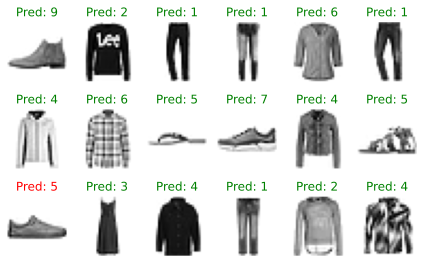

In [ ]:
### Utilisation de cette fonction pour illustrer les prédictions du modèle à 2 couches, sur les images d'origine
yp = model_dnn_4(X)
plot_images(X, y, yp, 3, 6)

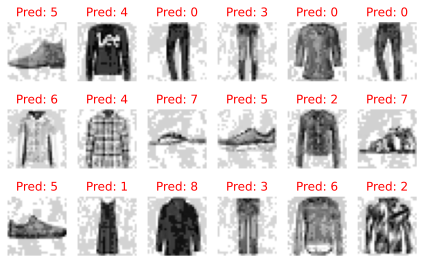

In [ ]:
### Utilisation de cette fonction pour illustrer les prédictions du modèle à 2 couches, sur les images attaquées
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)



Avec des modifications relativement mineures des images (aucune ne modifierait notre propre prédiction du label de l'image), le taux de prédictions incorrectes augmente de façon importante. Il est important de souligner ici que les réseaux entièrement connectés (fully connected networks) sont particulièrement sensibles à ces problèmes, tandis que les réseaux de neurones convolutifs (ConvNets) le sont un peu moins : voyons à quoi ressemble la même attaque pour notre modèle CNN.

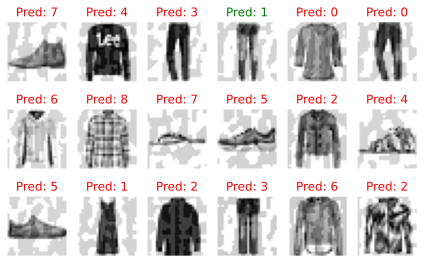

In [ ]:
### Utilisation de cette fonction pour illustrer les prédictions du modèle convolutionnel, sur les images attaquées
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

**Sur le modèle CNN, nous avons donc un "rescapé", prédit correctement, tandis que sur les modèles non convolutifs, plus aucun item ne l'est : ces résultats sont plus dégradés qu'avec les données MNIST, pour lesquelles le modèle CNN parvenait encore à effectuer plusieurs prédictions correctes, et pour lesquelles le modèle non convolutif en faisait encore une correctement...**

Voir les exemples visuellement est intéressant, mais évaluons la performance des méthodes d'attaque de manière un peu plus rigoureuse. À quoi ressemblent les erreurs de test de nos classificateurs lorsqu'ils sont évalués contre l'attaque adversariale FGSM ?

In [ ]:
#fonction qui évalue la robustesse d'un modèle aux attaques adversares et qui suit la performance du modèle pendant l'attaque
def epoch_adversarial(model, loader, attack, *args):
    '''
    model : Le modèle de réseau de neurones à tester (par exemple, un classificateur CNN ou DNN).
    loader : Un DataLoader PyTorch qui fournit les données (par exemple, les images et leurs labels).
    attack : Une fonction d'attaque qui génère les perturbations adverses à appliquer aux images pour tester la robustesse du modèle.
    *args : Des arguments supplémentaires qui seront passés à la fonction d'attaque. Cela permet de rendre la fonction flexible et d'utiliser différents types d'attaques
    (comme FGSM, PGD, etc.).
    '''
    total_loss, total_err = 0.,0.
    for X,y in loader: #la boucle for parcourt les mini-batchs du DataLoader loader
        X,y = X.to(device), y.to(device) #X.to(device) et y.to(device) déplacent les données vers le périphérique approprié (CPU ou GPU) en fonction de la variable device
        delta = attack(model, X, y, *args) #appelle la fonction d'attaque (par exemple, FGSM, PGD, etc.) pour générer les perturbations adverses delta qui seront ajoutées à l'image X
        yp = model(X+delta) #le modèle fait une prédiction sur les images perturbées (X + delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
    #en sortie : l'erreur et la perte moyennes sur le modèle testé sur les images attaquées

In [ ]:
#affichage des sorties de cette fonction pour chacun de nos modèles
print("2-layer DNN taux d'erreur moyen :", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN taux d'erreur moyen :", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN taux d'erreur moyen :", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN taux d'erreur moyen : 0.9537
4-layer DNN taux d'erreur moyen : 0.9164
        CNN taux d'erreur moyen : 0.9645


**Alors que sur le jeu de données MNIST, le réseau CNN se distinguait par un taux d'erreur moyen moitié moindre que ses "cousins" non convolutifs, ici, ce n'est pas le cas : il a même un taux d'erreur moyen supérieur à eux, sur ce jeu de données plus complexe.**

In [ ]:
#affichage des sorties de cette fonction pour chacun de nos modèles
print("2-layer DNN perte moyenne :", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[1])
print("4-layer DNN perte moyenne :", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[1])
print("        CNN perte moyenne :", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[1])

2-layer DNN perte moyenne : 6.971030282974243
4-layer DNN perte moyenne : 5.913490257263184
        CNN perte moyenne : 7.473749527931213


Avant de continuer, il y a quelques points importants à souligner concernant FGSM. Tout d'abord, il est important de souligner que FGSM est spécifiquement une attaque sous une contrainte de norme $\ell_\infty$ : FGSM n'est en réalité qu'une seule étape de descente de gradient projetée sous la contrainte $\ell_\infty$. Ainsi, nous devons considérer et évaluer FGSM dans le contexte d'autres attaques $\ell_\infty$. Mais il est également très facile de généraliser cette procédure (et d'autres) à d'autres normes, un sujet que nous aborderons en détail ci-dessous.

Le deuxième point à souligner est que, si vous vous rappelez les méthodes que nous avons présentées dans le chapitre précédent, il devrait être évident que FGSM est exactement l'attaque optimale contre un modèle de classification binaire linéaire sous la norme $\ell_\infty$. Cela devrait offrir une meilleure compréhension de ce que fait FGSM : il suppose que l'approximation linéaire de l'hypothèse donnée par son gradient au point $x$ est une approximation raisonnablement bonne de la fonction sur toute la région $\|\delta\|_\infty \leq \epsilon$. Cependant, cela met également en évidence immédiatement les inconvénients potentiels de l'attaque FGSM : parce que nous savons que les réseaux neuronaux ne sont pas en réalité linéaires, même sur une région relativement petite, si nous voulons une attaque plus puissante, il est probable que nous devions envisager de meilleures méthodes pour maximiser la fonction de perte qu'une simple étape de descente de gradient projetée.


### Descente de gradient projetée

Cette discussion nous amène immédiatement à la prochaine approche que nous souhaitons considérer pour maximiser le problème d'optimisation interne, à savoir simplement effectuer une descente de gradient projetée (c'est-à-dire la procédure ci-dessus, mais en l'itérant, avec une taille de pas plus petite). [Note : techniquement, il s'agit d'une ascension de gradient, car nous maximisons une fonction plutôt que de la minimiser, mais il est courant de simplement se référer à ce processus sous le terme "descente de gradient".] Cette approche a également été appelée la "procédure itérative de base" lors de sa première apparition dans la littérature sur les attaques adverses, mais par essence, c'est simplement le choix évident de la manière dont nous pourrions maximiser l'objectif interne un peu plus soigneusement que avec FGSM. Pour réitérer l'approche de base (qui est en fait décrite directement ci-dessus dans la discussion sur FGSM, et c'est aussi l'approche que nous avons utilisée dans la section introductive), l'algorithme de base de la descente de gradient projetée (PGD) consiste simplement à itérer les mises à jour.

Répéter :

\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}


où $\mathcal{P}$ désigne la projection sur la boule d'intérêt (par exemple, le découpage dans le cas de la norme $\ell_\infty$). Bien sûr, avec PGD, nous avons maintenant plus de choix à faire lors de la spécification de l'attaque, comme la taille du pas elle-même, et le nombre d'itérations (nous discuterons de quelques règles empiriques dans un instant, une fois que nous aurons présenté une version légèrement modifiée de l'itération ci-dessus). Nous pouvons implémenter cette attaque de la manière suivante, où ici nous allons implémenter la procédure de descente de gradient nous-mêmes plutôt que de nous appuyer sur l'un des optimisateurs de PyTorch, car nous voulons voir ce qui se passe de manière un peu plus explicite (l'optimiseur SGD de PyTorch inclut également des termes comme le momentum, qui parviennent généralement à optimiser le terme interne de manière plus efficace, mais nous voulons avoir le moins de procédures "boîte noire" possibles ici).

In [ ]:
#fonction utilisée pour générer des exemples adverses
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward() #Cette ligne effectue la rétropropagation pour calculer les gradients de la perte par rapport à delta (les perturbations).
                        #Les gradients ainsi obtenus indiquent dans quelle direction il faut ajuster delta pour augmenter la perte, et donc améliorer l'attaque adverse.
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
              #delta.grad.data : Les gradients de la perte par rapport à delta calculés lors de la rétropropagation.
              #alpha : La taille du pas utilisée pour ajuster delta. Cela détermine l'amplitude de chaque mise à jour de la perturbation.
              #X.shape[0] : La taille du batch (nombre d'exemples dans X), utilisée pour ajuster l'ampleur de la mise à jour en fonction de la taille du lot.
              #clamp(-epsilon, epsilon) : La fonction clamp garantit que les perturbations delta restent dans les limites définies par la contrainte de la boule de norme infinie
        delta.grad.zero_()#réinitialise les gradients de delta à zéro après chaque itération
    return delta.detach()

Voyons d'abord quelques exemples que nous générons avec cette méthode sur le modèle CNN.

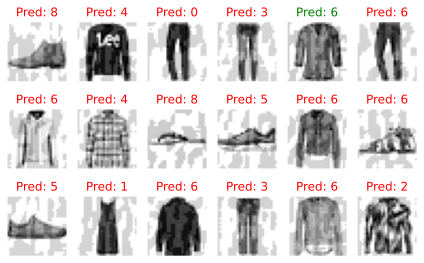

In [ ]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

**Comme avec les données MNIST, l'attaque ne semble pas beaucoup plus efficace que FGSM - voire elle est ici d'efficacité strictement égale sur les exemples affichés...**

Nous utilisons ici une taille de pas grande $\alpha=1e4$, sans l'avoir justifié. En fait cela est dû au fait que le gradient par rapport à $\delta$ et $\delta=0$ est généralement très petit pour les exemples eux-mêmes. Regardons cela de plus près.

In [ ]:
delta = torch.zeros_like(X, requires_grad=True)#torch.zeros_like(X) crée un tensor de zéros de la même forme (même taille, même type de données) que X ;
                                               #requires_grad=True indique que nous voulons suivre les gradients de delta lors de la rétropropagation.
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item()) #affiche la moyenne des gradients absolus de delta
#Si cette valeur est très faible, cela pourrait indiquer que les gradients sont presque nuls au point de départ (lorsque delta = 0),
#ce qui peut expliquer pourquoi les attaques adverses peuvent ne pas être efficaces au départ ou pourquoi des pas de gradient de grande taille sont nécessaires
#pour que l'attaque soit efficace.

0.0003906972415279597


La valeur absolue moyenne du gradient pour un pixel donné est d'environ $10^{-4}$ au point initial $\delta=0$, donc nous devons la mettre à l'échelle avec un $\alpha$ relativement grand pour faire un quelconque progrès. Une fois que nous "sortons" de la région initiale autour de $\delta=0$, les gradients augmentent généralement considérablement en magnitude, et à ce moment-là, notre grand $\alpha$ devient trop grand, et la méthode fait un pas trop important vers la frontière (agissant effectivement comme FGSM).

**À part : descente de gradient la plus raide.** Pour résoudre ce problème, nous allons en réalité utiliser une méthode d'optimisation légèrement différente, connue sous le nom de méthode de la descente de gradient la plus raide (normalisée). Il s'agit d'une procédure d'optimisation complètement standard, décrite par exemple dans [\cite{Boyd}], mais comme elle diffère légèrement de l'algorithme traditionnel de descente de gradient, nous allons la décrire brièvement ici. De manière générale, si nous voulons minimiser une fonction $f : \mathbb{R}^n \rightarrow \mathbb{R}$ par rapport à l'entrée $z$, l'algorithme traditionnel de descente de gradient répète la mise à jour suivante :

\begin{equation} z := z - \alpha \nabla_z f(z) \end{equation}

Le problème avec cette mise à jour (que nous avons rencontré ci-dessus), c'est qu'elle est très sensible à l'échelle absolue du gradient et ajuste les paramètres selon une échelle qui correspond toujours à l'échelle relative des termes du gradient. En revanche, la méthode de descente de gradient la plus raide normalisée consiste à trouver une direction de mise à jour négative $v$, où _nous choisissons $v$ pour maximiser le produit scalaire entre $v$ et le gradient_, sous une contrainte de norme sur $v$. Autrement dit, la descente de gradient la plus raide normalisée effectue la mise à jour suivante :

\begin{equation} z := z - argmax_{|v| \leq \alpha} v^T \nabla_z f(z) \end{equation}

Dans le cas où nous utilisons une contrainte de norme $\ell_2$​ sur $v$, l'argmax a la solution analytique suivante :

\begin{equation} argmax_{|v|_2 \leq \alpha} v^T \nabla_z f(z) = \alpha \frac{\nabla_z f(z)}{|\nabla_z f(z)|_2} \end{equation}

Ainsi, le pas correspond à une version de la descente de gradient où nous normalisons le vecteur gradient pour qu'il ait une norme unitaire. De manière similaire, si nous utilisons une contrainte de norme $\ell_\infty$​ sur $v$, alors, selon la même logique que celle que nous avons vue dans le chapitre précédent concernant l'attaque adverse optimale contre une fonction linéaire, l'argmax est donné par :

\begin{equation} argmax_{|v|_\infty \leq \alpha} v^T \nabla_z f(z) = \alpha \cdot \mathrm{sign}(\nabla_z f(z)) \end{equation}


Revenons à notre attaque adverse sur les réseaux profonds : il est assez courant de choisir une norme de descente de gradient la plus raide pour correspondre à la norme par rapport à laquelle nous minimisons finalement, donc pour une attaque avec une norme $\ell_\infty$​ bornée, nous allons utiliser la descente de gradient la plus raide normalisée projetée sous la norme $\ell_\infty$​ (qui, tout comme la descente de gradient, projette à nouveau dans la boule autorisée, après un pas de gradient) au lieu de la descente de gradient traditionnelle. D'après l'équation ci-dessus, il devrait être évident que cela correspond essentiellement à de nombreux pas de "mini-FGSM", d'où le nom original de "l'algorithme itératif de base" pour cette approche. Et bien que cela soit techniquement un algorithme d'optimisation légèrement différent de la descente de gradient, la méthode est toujours largement appelée "descente de gradient projetée" et cette version ici constitue la véritable méthode PGD employée par les attaques modernes. Voyons ce que cela donne avec PyTorch.

In [ ]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)#on a modifié la formule en conséquence
        delta.grad.zero_()
    return delta.detach()

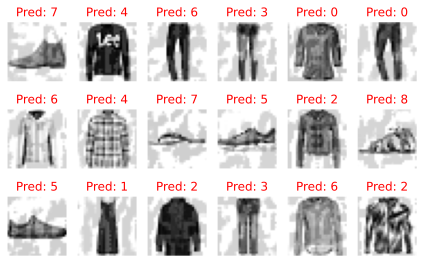

In [ ]:
### Illustration sur les images attaquées, avec le modèle CNN
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

**Cette fois (contrairement au cas du jeu de données MNIST pour lequel nous ne créions toujours pas ici d'exemples adverses pour tous les cas), nous avons réussi à créer un exemple adverse à chaque image : c'est bien mieux que l'algorithme FGSM.** Il est également beaucoup plus facile de choisir la taille des pas qu'auparavant. Étant donné que la taille du pas $\alpha$ est à la même échelle que la limite totale de la perturbation $\epsilon$, il est logique de choisir $\alpha$ comme une fraction raisonnablement petite de $\epsilon$, puis de choisir le nombre d'itérations comme un petit multiple de $\epsilon/\alpha$. Voyons comment ces paramètres se comportent lors de l'attaque sur l'ensemble de test complet.

In [ ]:
print("2-layer DNN taux d'erreur moyen :", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN taux d'erreur moyen :", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN taux d'erreur moyen :", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN taux d'erreur moyen : 0.9768
4-layer DNN taux d'erreur moyen : 0.9877
CNN taux d'erreur moyen : 0.9988


C'est une amélioration raisonnable de l'efficacité de notre attaque par rapport à l'attaque FGSM. Il existe une dernière stratégie que nous pouvons utiliser pour améliorer encore un peu les performances : la randomisation. Cette technique n'est pas souvent utilisée en pratique, car elle est relativement coûteuse, mais elle met en évidence un point important.

Les performances du PGD sont encore limitées par la possibilité d'optima locaux dans l'objectif. Et bien qu'il ne soit pas possible d'éviter complètement la réalité des optima locaux, nous pouvons atténuer légèrement le problème en effectuant des redémarrages aléatoires. Autrement dit, nous ne lançons pas PGD une seule fois, mais plusieurs fois, à partir de différentes positions aléatoires dans la boule $\ell_\infty$​ de notre choix. Cela donne une amélioration mineure mais pas complètement négligeable, mais surtout, cela met en évidence le fait qu'il y a des optima locaux que PGD, en partant du point zéro, finira par trouver, et qui peuvent être évités dans une certaine mesure simplement par randomisation. En revanche, l'approche telle qu'elle est décrite naïvement ci-dessous augmente également le temps d'exécution d'un facteur égal au nombre de redémarrages, ce qui peut ne pas être pratique dans de nombreux cas.


In [ ]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta

In [ ]:
print("CNN taux d'erreur moyen :", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN taux d'erreur moyen : 0.9997


**"l'approche telle qu'elle est décrite naïvement [ici] augmente également le temps d'exécution d'un facteur égal au nombre de redémarrages, ce qui peut ne pas être pratique dans de nombreux cas." Effectivement, le temps de calcul est incroyablement plus long...**

**Dans le cas de notre jeu de données Fashion-MNIST, c'est pour passer de 0,998 à 0,999 en taux moyen d'erreur : pas rentable vu la hausse très importante du temps de calcul !!**

**Pour le jeu de données MNIST, c'était mieux : on passait de 0,7432 à 0,7648, soient 0,02 points d'écart**

### Attaques ciblées

Ce que nous avons considéré jusqu'à présent sont des attaques « non ciblées », c'est-à-dire qu'elles tentent essentiellement de changer l'étiquette en n'importe quelle alternative, plutôt que de la changer en une alternative particulière. Comme autre tâche, que nous avons brièvement vue dans l'introduction, nous pouvons modifier l'attaque pour tenter de convertir la prédiction en une alternative particulière. Il s'agit d'une tâche connue sous le nom d'« attaque ciblée », et elle peut être réalisée en utilisant la même stratégie globale que celle que nous avons utilisée précédemment. Cependant, dans ce cas, la seule différence est qu'au lieu de maximiser la perte de l'étiquette réelle, nous maximisons la perte de l'étiquette réelle et nous minimisons également la perte pour l'étiquette alternative. Cela revient à résoudre le problème d'optimisation interne suivant :

\begin{equation} \maximize_{|\delta| \leq \epsilon} \left ( \ell(h_\theta(x + \delta), y) - \ell(h_\theta(x + \delta), y_{\mathrm{targ}}) \right ) \equiv \maximize_{|\delta| \leq \epsilon} \left ( h_\theta(x + \delta){y{\mathrm{targ}}} - h_\theta(x + \delta)_y \right ) \end{equation}

Voyons ce que cela donne, en utilisant une attaque PGD (sans redémarrages aléatoires). Notez que pour atteindre notre classe ciblée dans la plupart de ces cas, nous utilisons une région de perturbation légèrement plus grande, $\epsilon=0.2$.



In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum() #yp[:, y_targ] extrait les prédictions du modèle pour l'étiquette cible ;
                                                                  #yp.gather(1, y[:, None])[:, 0] extrait les prédictions du modèle pour l'étiquette réelle
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()

    return delta.detach()


Voyons comment faire en sorte que l'étiquette de classe de toutes les équations soit 2.

In [ ]:
def pgd_linf_exact(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X)
        loss = (yp[:,y_targ]-yp.gather(1,y[:,None])[:,0]).sum() #yp[:, y_targ] extrait les prédictions du modèle pour l'étiquette cible ;
                                                                  #yp.gather(1, y[:, None])[:, 0] extrait les prédictions du modèle pour l'étiquette réelle
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()

    return delta.detach()

**Voici les prédictions sur les images non perturbées :**

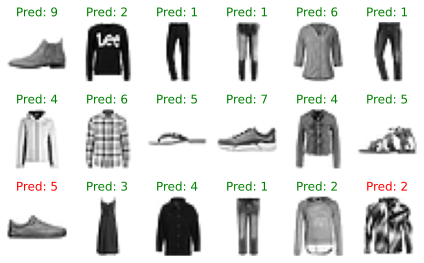

In [ ]:

yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

**Et voici les prédictions sur les images victimes d'une attaque ciblant la classe 2 :**

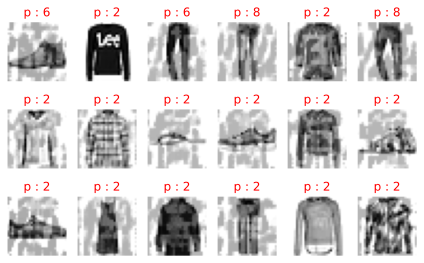

In [ ]:

delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2) #y_targ=2
#print(delta)
#epsilon=0.2, alpha=1e-2,
yp = model_cnn(X+delta)
plot_images(X+delta, y, yp, 3, 6)





Cela semble plutôt bien : quoiqu'avec un $\epsilon$ légèrement plus grand, nous pouvons tromper le classificateur pour qu'il prédise que tous les exemples sont de la classe 2 (notez que le 2 réel reste inchangé, car la fonction de perte dans ce cas est toujours exactement nulle). Essayons maintenant d'utiliser une classe cible de 0 à la place.

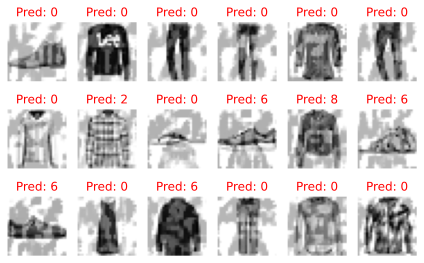

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)#y_targ=0
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Bien que nous soyons capables de tromper le classificateur pour tous les chiffres non nuls, il est important de souligner que nous n'atteignons en réalité pas toujours la classe cible dans tous les cas. Cela s'explique par le fait que l'objectif d'optimisation que nous maximisons est le logit de la classe zéro moins le logit de la classe réelle. Mais en réalité, nous ne nous soucions pas de ce qui se passe pour les autres classes, et dans certains cas, la meilleure façon d'augmenter le logit de la classe 0 est d'augmenter encore plus le logit d'une autre classe. Nous pouvons contourner ce problème en modifiant notre objectif pour maximiser le logit de la classe cible et minimiser tous les autres logits, c'est-à-dire :

\begin{equation}
\maximize_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta)_{y_{\mathrm{targ}}} - \sum_{y' \neq y_{\mathrm{targ}}} h_\theta(x + \delta)_{y'} \right )
\end{equation}

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

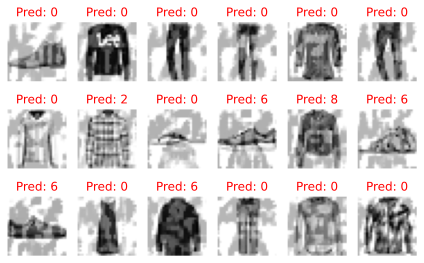

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)



C'est un objectif plus difficile que le précédent, donc nous ne sommes pas capables de tromper le classificateur autant que cela. Mais quand nous réussissons à tromper le classificateur, celui-ci prédit plus régulièrement (même si ce n'est pas encore parfait) la classe cible.

### Normes autres que $\ell_\infty$

Jusqu'à présent, nous nous sommes concentrés uniquement sur des attaques où $\delta$ a une norme $\ell_\infty$ bornée (et, de plus, où nous ne nous préoccupons pas de la coupe des valeurs à l'intervalle réel autorisé $[0,1]$ de l'image). Dans cette section, nous allons enfin aller au-delà de cela, et considérer la norme $\ell_2$ en plus, tout en incluant explicitement la contrainte selon laquelle $x + \delta$ doit effectivement se trouver dans l'intervalle $[0,1]$.

La bonne nouvelle est que les stratégies ci-dessus se ramènent exactement à ce cas. Le cas $\ell_2$ est particulièrement simple : nous utilisons simplement la méthode de descente de gradient projetée normalisée pour la boule $\ell_2$, qui, comme mentionné ci-dessus, a la forme suivante : \begin{equation} \delta := \mathcal{P}\epsilon \left(\delta - \alpha \frac{\nabla\delta \ell(h_\theta(x+\delta),y)}{|\nabla_\delta \ell(h_\theta(x+\delta),y)|2}\right ) \end{equation} où $\mathcal{P}\epsilon$ désigne maintenant la projection sur la boule $\ell_2$ de rayon $\epsilon$. Cette projection est simplement donnée par la normalisation de $\delta$ pour qu'elle ait une norme $\ell_2$ égale à $\epsilon$ si elle est supérieure à $\epsilon$, c'est-à-dire : \begin{equation} \mathcal{P}_\epsilon(z) = \epsilon\frac{z}{\max{\epsilon, |z|_2}}. \end{equation} Ainsi, notre attaque finale ressemble à ce qui suit.


In [ ]:
def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)
        delta.grad.zero_()

    return delta.detach()

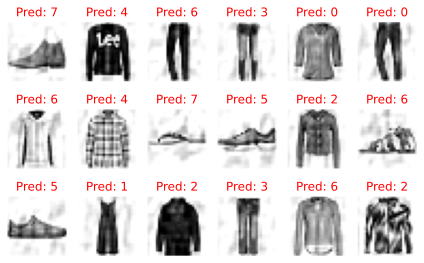

In [ ]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.9488
4-layer DNN: 0.9562
CNN: 0.9986


Notez que l'$\epsilon$ que vous devez considérer pour les perturbations de norme $\ell_2$ est plus grand que celui nécessaire pour les perturbations de norme $\ell_\infty$, car le volume de la boule $\ell_2$ est proportionnel à $\sqrt{n}$ fois le volume de la boule $\ell_\infty$, où $n$ est la dimension de l'entrée (techniquement, il y a un facteur de mise à l'échelle supplémentaire de $\sqrt{2}/\sqrt{\pi e}$ pour que les volumes correspondent plus précisément dans les dimensions supérieures, ce qui découle de quelques formules simples pour le volume des boules $\ell_p$, mais nous ne le prouverons pas ici). Ainsi, pour MNIST, une boule $\ell_2$ ayant le même volume qu'une boule $\ell_\infty$ de rayon $\epsilon = 0.1$ est approximativement égale à une boule $\ell_2$ de rayon $\frac{\sqrt{2 \cdot 784}}{\sqrt{\pi e}} \cdot 0.1 \approx 1.35$. Et nous utiliserons un rayon légèrement plus grand de $\epsilon = 2$, car empiriquement les classificateurs sont capables de gérer des perturbations $\ell_2$ légèrement plus grandes que les perturbations $\ell_\infty$.

L'élément clé à noter ici est que, bien que les attaques $\ell_\infty$ entraînent un bruit faible partout dans l'image (précisément parce que c'est la perturbation autorisée sous la boule $\ell_\infty$), les attaques $\ell_2$ entraînent des perturbations qui sont plus localisées dans l'image, car nous pouvons "échanger" une perturbation plus grande à un point de l'espace contre une perturbation plus faible à un autre point.

Toutes les mêmes considérations s'appliquent également aux attaques $\ell_1$ ; nous pouvons dériver un algorithme PGD similaire (la descente de gradient la plus raide pour $\ell_1$ correspond à l'optimisation de la seule coordonnée ayant la plus grande magnitude de gradient) et projeter à nouveau dans la boule $\ell_1$. Nous ne l'implémenterons pas ici, principalement parce que la projection sur la boule $\ell_1$ est bien plus compliquée que pour les boules $\ell_\infty$ ou $\ell_2$, mais la même méthodologie fonctionne. Et les attaques $\ell_1$, par la nature de la norme $\ell_1$, favorisent la parcimonie dans la perturbation $\delta$, c'est-à-dire qu'elles n'ajusteront que quelques pixels dans l'image.


### Que dire de toutes ces autres attaques dont vous avez entendu parler ?

En guise de conclusion, nous devrions souligner que la présentation que nous proposons ici est différente de l'ensemble "standard" des attaques souvent présentées dans de nombreux articles. Dans la plupart des papiers sur les exemples adversariaux, vous verrez probablement mentionner des attaques comme FGSM, mais aussi CW [\cite{}], DeepFool [\cite{}], et bien d'autres. Bien que mentionner ces noms d'attaques soit utile à des fins historiques (les articles associés ont souvent été les premiers à présenter et à étudier empiriquement ces méthodes), à ce stade, nous pensons qu'il est plus utile de faire référence aux attaques de manière plus formelle en fonction de 1) la norme de la boule de perturbation qu'elles considèrent, et 2) la méthode qu'elles utilisent pour optimiser sur cette boule de norme. Toutes les attaques dans la littérature sont des stratégies qui impliquent ces deux éléments, et les méthodes PGD sont empiriquement les plus efficaces pour optimiser sur pratiquement n'importe quelle boule de norme. Mais (et encore une fois, cela représente notre avis à nous, Zico et Aleksander), se référer aux attaques par la méthode nommée pour les résoudre masque la similarité fondamentale entre toutes les différentes approches. Du moins, nous espérons que les méthodes d'attaque pourront être très explicites sur la nature précise de la boule de norme et de la stratégie d'optimisation qu'elles utilisent, plutôt que de la présenter uniquement en termes d'étapes algorithmiques.


## Résoudre exactement la maximisation intérieure (optimisation combinatoire)

Maintenant que nous avons considéré l'approche "standard" pour générer des exemples adversariaux en pratique, considérons une approche alternative pour résoudre exactement le problème de maximisation intérieure à l'aide de l'optimisation combinatoire. Notez que, comme dans le cas linéaire, nous ne résolvons pas exactement le problème de maximisation intérieure dans le cas multiclasses, mais nous pouvons déterminer exactement si un exemple adversarial existe dans un certain rayon, en considérant des attaques ciblées contre chaque classe possible. Notre stratégie utilisera finalement la programmation linéaire en nombres entiers (une approche combinatoire), et bien que nous ne nous attendions pas à ce que ces approches soient évolutives pour des problèmes de grande envergure, pour de petits modèles elles fournissent un moyen de raisonner exactement sur le réseau de neurones.


### Une formulation contrainte des attaques ciblées (An constrained formulation of targetted attacks).

Pour commencer, considérons à nouveau une attaque ciblée contre un classificateur profond, en nous spécialisant cette fois pour le réseau de neurones à propagation avant basé sur ReLU que nous avons présenté au tout début de ce chapitre,

\begin{equation}
\begin{split} z_1 & = x\\
z_{i+1} & = f_i(W_i z_i + b_i),
i,\ldots,d \\ h_\theta(x) & = z_{d+1} \end{split} \end{equation} où $f_i(z) = \mathrm{ReLU}(z)$ pour $i=1,\ldots,d-1$, et $f_d(x) = x$ (c'est-à-dire que la dernière couche sera les logits de classe).

Considérons d'abord comment nous pouvons formuler une attaque adversariale ciblée comme un problème d'optimisation. Comme discuté précédemment, une attaque ciblée cherchera à minimiser le logit de la classe réelle $h_\theta(x+\delta)y$ et à maximiser le logit de la classe cible $h\theta(x+\delta){y{\mathrm{targ}}}$ ; si nous essayons de réaliser une attaque ciblée pour $y_{\mathrm{targ}}$ égal à toutes les autres étiquettes de classe $y' \neq y$, alors nous savons que si un exemple adversarial existe, cette procédure le trouvera pour un réglage de $y'$. Nous pouvons reformuler l'attaque ciblée comme un problème d'optimisation, mais cette fois, nous allons rendre explicite la structure réelle du réseau dans le problème d'optimisation. Plus précisément, nous allons formuler le problème d'optimisation comme un problème sur l'entrée $x$ et toutes les actions intermédiaires $z_i$, mais avec des contraintes qui contraignent ces activations à suivre le comportement du réseau de neurones. Nous nous concentrerons également sur le cas des attaques $\ell_\infty$, bien que d'autres normes soient également possibles (bien que toutes ne puissent pas être écrites sous forme de programmes linéaires entiers mixtes, et donc certaines soient plus difficiles à résoudre en pratique). Plus précisément, nous pouvons écrire le problème comme suit :

\begin{equation} \DeclareMathOperator*{\minimize}{minimize} \DeclareMathOperator*{\subjectto}{subject to} \begin{split} \minimize_{z_{1,\ldots,d+1}} & (e_y - e_{y_{\mathrm{targ}}})^T z_{d+1} \\subject  to ||z_1 - x||\infty \leq \epsilon \\ & z{i+1} = \max{0, W_i z_i + b_i}, i=1,\ldots, d-1 \\ & z_{d+1} = W_d z_d + b_d \end{split} \end{equation} où $e_i$ désigne la base unitaire, c'est-à-dire un vecteur avec un un à la $i$-ème position et des zéros partout ailleurs ; et où nous avons supprimé le terme explicite $\delta$ au profit d'une contrainte qui exige simplement que $z_1$ (l'entrée de la première couche) soit dans un rayon $\epsilon$ autour de $x$.



### Une formulation en programmation linéaire en nombres entiers (A mixed integer programming formulation)


Bien qu'il s'agisse d'une formulation relativement simple du problème d'attaque ciblée, elle n'est pas sous une forme que les solveurs pourront réellement résoudre. Le problème spécifique ici est la contrainte d'égalité impliquant l'opérateur ⁡max, qui n'est pas une contrainte convexe, et n'est pas non plus gérée de manière native par la plupart des solveurs d'optimisation. Pour résoudre le problème, nous devons donc le convertir sous une autre forme, spécifiquement un programme linéaire en nombres entiers (MILP). Un MILP binaire est un problème d'optimisation qui consiste en un objectif linéaire (c'est-à-dire $c^T z$ pour la variable d'optimisation $z$ et le vecteur de coefficients $c$) ; des contraintes d'égalité et d'inégalité linéaires
(c'est-à-dire $A z = b$ et/ou $Gz \leq h$ pour les matrices $A,G$ et les vecteurs $b,h$) ; t des contraintes binaires sur certaines des variables $z_i \in \{0,1\},\forall i \in \mathcal{I}$, où $\mathcal{I}$ est un sous-ensemble des variables d'optimisation. Ces problèmes sont rendus difficiles par la présence de la contrainte entière non convexe $z_i \in \{0,1\}$; sans ces contraintes, le problème deviendrait un programme linéaire, qui est résoluble en un temps polynomial en fonction de la taille du problème. Mais les MILP en général sont NP-difficiles, et donc nous ne nous attendons pas à pouvoir étendre cette approche à la taille des réseaux de neurones modernes. Cependant, pour les petits problèmes, les MILP sont un domaine extrêmement bien étudié, et il existe des approches qui sont considérablement plus évolutives que la méthode naïve de force brute consistant à essayer toutes les configurations possibles des variables binaires.

Comment, cependant, exprimer la contrainte $z_{i+1} = \max\{0, W_i z_i + b_i\}$
en utilisant des contraintes linéaires et des contraintes entières binaires ? L'approche que nous utilisons ici est connue sous le nom de linéarisation et c'est une pratique tout à fait standard dans la littérature sur la programmation en nombres entiers. Supposons que nous ayons une borne inférieure et supérieure connues pour les valeurs que  $W_i z_i + b_i$​ peut prendre, que nous noterons respectivement $l_i$​ et $u_i$​ (notez que ces valeurs sont fixes). Nous introduirons également un ensemble de variables binaires $v_i$​ de la même taille que $z_{i+1}$​. Ensuite, nous affirmons que les inégalités suivantes sont équivalentes à la contrainte $z_{i+1} = \max\{0, W_i z_i + b_i\}$ :

\begin{equation} \begin{split} z_{i+1} & \geq W_i z_i + b_i \ z_{i+1} & \geq 0 \ u_i \cdot v_i &\geq z_{i+1} \ W_i z_i + b_i & \geq z_{i+1} + (1-v_i) l_i \ v_i & \in {0,1}^{|v_i|} \end{split} \end{equation}

La meilleure façon de comprendre ces contraintes est simplement par exemple (mais n'hésitez pas à passer les deux prochains paragraphes si vous êtes prêt à simplement accepter notre travail sur ce sujet).

Supposons d'abord que $W_i z_i + b_i > 0$ (pour simplifier, vous pouvez considérer ces valeurs comme simplement des scalaires pour cette discussion, mais bien sûr cela s'applique élément par élément au vecteur). Si nous choisissons $v_i = 0$, alors la troisième contrainte impliquerait que $z_{i+1} \leq 0$, tandis que la première contrainte impliquerait que $z_{i+1} \geq W_i z_i + b_i > 0$, ce qui conduit à une solution infaisable ; ainsi, pour $W_i z_i + b_i > 0$, nous devons choisir $v_i = 1$. Et si nous choisissons $v_i = 1$, alors les contraintes se réduisent à

\begin{equation} \begin{split} z_{i+1} & \geq W_i z_i + b_i \ z_{i+1} & \geq 0 \ u_i & \geq z_{i+1} \ W_i z_i + b_i & \geq z_{i+1}, \end{split} \end{equation}

les premières et quatrièmes inégalités impliquent que $z_{i+1} = W_i z_i + b_i$, et les deuxièmes et troisièmes inégalités sont toujours satisfaites respectivement parce que 1) la première inégalité est plus stricte que la deuxième et 2) $u_i$​ est une borne supérieure de $W_i z_i + b_i$​, donc elle sera aussi supérieure à $z_{i+1}$​.

Inversement, supposons que $W_i z_i + b_i < 0$. Alors, choisir $v_{i+1}=1$ entraîne que la quatrième contrainte implique que $z{i+1} \leq W_i z_i + b_i < 0$, ce qui entre en conflit avec la contrainte $z_{i+1} \geq 0$. Par conséquent, nous devons choisir $v_{i+1} = 0$, où les contraintes se réduisent à

\begin{equation} \begin{split} z_{i+1} & \geq W_i z_i + b_i \ z_{i+1} & \geq 0 \ 0 & \geq z_{i+1} \ W_i z_i + b_i & \geq z_{i+1} + l_i. \end{split} \end{equation}

Alors, les deuxièmes et troisièmes contraintes impliquent que $z_{i+1} = 0$. Et les premières et quatrièmes contraintes sont satisfaites respectivement parce que 1) la deuxième inégalité est plus stricte que la première, et 2) $l_i$​ est une borne inférieure de $W_i z_i + b_i$​.

En d'autres termes, nous avons montré qu'avec ces contraintes, si $W_i z_i + b_i > 0$, alors $z_{i+1} = W_i z_i + b_i$​, et si $W_i z_i + b_i =< 0$, alors $z_{i+1} = 0$. Ce sont précisément les conditions de l'opération ReLU (encore une fois, la logique ci-dessus s'applique élément par élément à chaque entrée de $z_{i+1}$​, donc l'opération est effectivement une ReLU élément par élément).

### Trouver les bornes supérieures et inférieures

Il reste une question pour la formulation de la programmation entière : comment trouver les bornes supérieures et inférieures $l_i$ et $u_i$. Mathématiquement, cela n'a en réalité pas d'importance : parce que la formulation ci-dessus est vraie pour n'importe quelle valeur de borne supérieure et inférieure, nous pourrions simplement choisir $\ell_i = -10^{100}$, $u_i = 10^{100}$ et nous sentir tranquilles dans le fait que, puisque ces valeurs sont bien plus grandes que tout ce que notre réseau pourrait atteindre, nous avons des bornes valides. Malheureusement, le temps de solution pratique des solveurs de programmation entière dépendra fortement de la qualité des bornes supérieures et inférieures. Et de manière intéressante, nous pouvons en fait calculer la valeur exacte de ces bornes de la même manière que nous calculons les attaques ciblées : tout comme une attaque ciblée minimiserait $(e_y - e_{y_{\mathrm{targ}}})$ multiplié par la dernière couche de poids dans un réseau, nous pourrions calculer une borne supérieure ou inférieure en minimisant la valeur d'activation unique dans une couche intermédiaire, c'est-à-dire que $(l_k)j$ serait la solution au problème d'optimisation suivant : \begin{equation} \begin{split} \minimize{z_{1,\ldots,k+1}} ;; & e_j^T z_{k+1} \ \mbox{subject to} ;; & |z_1 - x|\infty \leq \epsilon \ & z{i+1} = \max{0, W_i z_i + b_i}, ;; i=1,\ldots, k-1 \ & z_{k+1} = W_k z_k + b_k. \end{split} \end{equation}

Bien que cela soit une solution exacte pour les bornes supérieures et inférieures, cela est extrêmement peu pratique, car nous résolvons essentiellement deux problèmes de programmation entière pour chaque unité cachée dans le réseau. Il est donc beaucoup plus pratique de choisir simplement un ensemble de bornes beaucoup plus larges (mais pas complètement vides) qui sont très rapides à calculer. Un choix naturel ici est d'utiliser des bornes par intervalles simples. Si nous avons des bornes sur $z$, $\hat{l} \leq z \leq \hat{u}$ (nous abandonnons l'indice de la couche, car il s'agit d'un problème générique et le nombre d'indices commencerait à devenir très encombré), la question est : quelle taille ou petite taille pourrions-nous donner au terme $W z + b$ ?

Considérons une entrée unique $(W z + b)i$, donnée par

\begin{equation} (W z + b)i = \sum{j} w{ij} z_j + b_i \end{equation}

où ici $W_{ij}$ désigne l'entrée dans la $i$-ème ligne et $j$-ème colonne de $W$, $z_j$ et $b_i$ désignent respectivement les $j$-ème et $i$-ème entrées de $z$ et $b$. Si nous voulons minimiser ce terme, en ayant une liberté totale sur notre choix de $z$ dans ses bornes, il devrait être clair que, chaque fois qu'une entrée de $W_{ij}$ est négative, nous devrions choisir $z_j = \hat{u}j$ et chaque fois que $W{ij}$ est positif, nous devrions choisir $z_j = \hat{l}_j$ (et inversement si nous essayons de maximiser la quantité totale). Ainsi, nous avons l'ensemble des bornes sur $W z + b$, donné par

\begin{equation} \max{W,0} \hat{l} + \min{W,0} \hat{u} + b \leq (W z +b) \leq \max{W,0} \hat{u} + \min{W,0}\hat{l}. \end{equation}

Notez que ces bornes sont assez larges, car elles permettent effectivement un terme $z$ complètement différent pour minimiser une colonne $i$ par rapport à d'autres colonnes $i'$. Cependant, elles sont extrêmement rapides à calculer, et pour les réseaux profonds, nous pouvons utiliser cette stratégie pour borner les couches linéaires, et simplement tronquer les bornes inférieures et supérieures à zéro pour les opérations ReLU. Notez également que bien que l'opération ci-dessus soit la plus évidente pour les couches complètement connectées, elle s'applique tout autant aux couches convolutionnelles : les convolutions sont également des opérateurs linéaires qui peuvent être représentés sous forme matricielle, et la même structure s'applique si nous prenons simplement le min/max sur les poids du filtre au lieu des entrées de $W$.

Ci-dessous se trouve le code qui calculera ces bornes par intervalles sur les types de modèles que nous avons présentés ci-dessus. Notez que pour rester conforme aux conventions de PyTorch sur les tailles de matrices, nous devons jouer un peu avec les transpositions, mais le code correspond exactement aux bornes que nous avons décrites ci-dessus, simplement capable de les calculer pour des mini-lots entiers.







In [ ]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []

    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t()
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t()
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])

        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

En aparté rapide (nous reviendrons sur ce point plus tard), nous pouvons en réalité utiliser cette stratégie pour obtenir déjà une borne sur les activations possibles de la dernière couche d'un réseau, bien que, comme nous le verrons sous peu, sous les modèles standards, ces bornes soient trop larges pour fournir directement beaucoup d'informations. Considérons notre réseau convolutionnel, et examinons la propagation de ces bornes par intervalles en partant d'une boule initiale $\ell_\infty$ autour des échantillons d'entrée. Notez qu'ici, il est assez facile de tronquer également les bornes par intervalles pour qu'elles soient dans l'intervalle $[0,1]$, donc nous allons également faire cela.

In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2810.7034 -3693.2307 -3243.204  -3302.5764 -3101.2117 -4382.451
 -2853.7024 -3971.508  -3659.9475 -4396.141 ]
upper bound:  [4151.2017 2839.1577 3490.1511 3290.6013 3680.069  3593.169  4331.2466
 3126.5342 3912.277  3132.9824]


**Ces bornes nous indiquent que pour une perturbation delta de $\epsilon=0.1$, le logit correspondant à la classe zéro pour le premier exemple de test Fashion-MNIST se trouve... quelque part dans l'intervalle $[-2810, 4151]$.** Ce n'est pas particulièrement utile pour déterminer quelle sera la prédiction, mais c'est mieux que les bornes $[-10^{100}, 10^{100}]$, donc cela aidera beaucoup pour le programme entier. Comme vous pouvez le voir dans la formule ci-dessus, ces bornes deviennent beaucoup plus faibles pour les réseaux profonds, car les erreurs dans les bornes ont le temps de s'accumuler à chaque couche successive. Par exemple, voici les bornes que nous obtenons pour les réseaux à deux couches et à quatre couches.

In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_2, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-19.060093 -23.559319 -19.615747 -23.45613  -20.227055 -23.69996
 -22.652315 -26.97802  -22.057907 -22.390982]
upper bound:  [16.463652 14.585894 18.5098   18.518467 18.27066  36.611374 23.251322
 23.166363 26.311735 25.812767]


In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_4, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-148.04697 -157.08464 -203.46063 -181.70195 -183.99045 -228.66742
 -167.82127 -243.24382 -189.13948 -218.36433]
upper bound:  [204.40553 176.98178 192.39407 137.84929 201.07233 210.58862 239.82283
 181.00305 177.23904 182.86417]


Mieux, mais ce n'est toujours pas particulièrement utile en soi. Nous reviendrons sur ce point sous peu, cependant, car avec la bonne procédure d'entraînement, de telles bornes peuvent en réalité être utiles. Pour l'instant, concentrons-nous cependant sur l'utilisation des bornes dans le programme entier.

###Une formulation finale de programmation entière

Mettons tout cela ensemble pour formuler une dernière version de la programmation entière (en combinant la formulation ReLU ci-dessus avec la borne de norme initiale et l'objectif pour l'attaque adversariale ciblée), donnée par

\begin{equation}
\begin{split}
\minimize_{z_{1,\ldots,d+1}, v_{1,\ldots,d-1}} \;\; & (e_y - e_{y_{\mathrm{targ}}})^T z_{d+1} \\
\subjectto \;\; & z_{i+1} \geq W_i z_i + b_i, \;\; i=1\ldots,d-1 \\
& z_{i+1} \geq 0, \;\; i=1\ldots,d-1 \\
& u_i \cdot v_i \geq  z_{i+1}, \;\; i=1\ldots,d-1 \\
& W_i z_i + b_i \geq z_{i+1} + (1-v_i) l_i, \;\; i=1\ldots,d-1 \\
& v_i \in \{0,1\}^{|v_i|}, \;\; i=1\ldots,d-1 \\
& z_1\leq x + \delta \\
& z_1 \geq x - \delta \\
& z_{d+1} = W_d z_d + b_d.
\end{split}
\end{equation}


Nous pouvons résoudre ce problème à peu près tel qu'il est énoncé ci-dessus, en utilisant la bibliothèque cvxpy. Notez que pour résoudre des programmes entiers, cvxpy a besoin d'un solveur backend compatible : dans notre cas, nous utilisons le solveur Gurobi, qui est gratuit pour un usage académique (y compris pour la recherche), mais qui nécessite une licence commerciale dans les autres cas. Vous pouvez essayer l'un des autres solveurs de programmation entière disponibles dans cvxpy, mais notez que la programmation entière est un domaine où les solveurs gratuits sont encore largement en retard par rapport aux solveurs commerciaux en termes de rapidité.

Notez qu'ici, pour simplifier, nous allons spécialiser la fonction pour travailler avec des réseaux ReLU entièrement connectés (c'est-à-dire composés uniquement de couches linéaires et ReLU, où l'on suppose que chaque couche linéaire est suivie d'une ReLU, sauf pour la dernière), mais elle peut également être appliquée à des réseaux plus généraux (par exemple, en prenant simplement la forme matricielle d'une convolution).


In [ ]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1

    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] +
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]

    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()

    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i],
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]

    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]

    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]

    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)


Afin de résoudre rapidement ce MILP sans simplifications supplémentaires, nous devons en réalité considérer un réseau encore plus petit que celui que nous avons utilisé jusqu'à présent. Le code suivant construira et entraînera un réseau à trois couches avec des unités cachées de taille 50 et 20. Comme précédemment, vous pouvez simplement charger le modèle si vous ne souhaitez pas l'entraîner.

In [ ]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(),
                            nn.Linear(50,20), nn.ReLU(),
                            nn.Linear(20,10)).to(device)

In [ ]:
# train model and save to disk
opt = optim.SGD(model_small.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_small, opt)
    test_err, test_loss = epoch(test_loader, model_small)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
torch.save(model_small.state_dict(), "model_small.pt")

0.308533	0.844318	0.230400	0.616100
0.182350	0.510388	0.181700	0.507756
0.161467	0.446117	0.162300	0.457196
0.150783	0.412725	0.151500	0.422073
0.141733	0.388509	0.147300	0.404530
0.134517	0.368773	0.154400	0.427665
0.128417	0.353300	0.137900	0.389525
0.125717	0.344078	0.144600	0.402276
0.121300	0.331776	0.137400	0.386394
0.119367	0.323686	0.144600	0.396956


In [ ]:
# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))


Formons maintenant le programme entier pour le premier exemple dans l'ensemble de test, avec l'objectif d'une attaque ciblée visant à changer cette étiquette en un zéro (l'étiquette réelle est un 7, et vous pouvez regarder l'exemple dans les figures que nous avons montrées dans les sections précédentes).

In [ ]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.zeros(10)
c[y[0].item()] = 1
c[2] = -1

prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)

Enfin, résolvons le programme entier en utilisant Gurobi.




**Partie non traitée car obtenir la licence pour installer Gurobi est compliqué depuis chez moi (il faudrait que je sois dans le réseau informatique de l'université, si je comprends bien...).**

In [ ]:
prob.solve(solver=cp.GUROBI, verbose=True)

NameError: name 'prob' is not defined

Comme l'objectif résultant est négatif, cela signifie que nous sommes capables de trouver une perturbation qui rend le logit de la classe cible plus grand que le logit de la classe originale, c'est-à-dire que nous sommes capables de construire un exemple adversarial. Dans ce cas, résoudre le MILP (avec 70 variables binaires) a pris moins d'une seconde, mais cela deviendra rapidement complètement intraitable pour des modèles plus grands (vous pouvez essayer de faire la même procédure avec nos modèles originaux ci-dessus). Nous pouvons également effectuer une vérification rapide pour valider la formulation en insérant la valeur initiale dans le modèle et en nous assurant que les dernières couches sont les mêmes que celles données par le MILP.


In [ ]:
print("Last layer values from MILP:", z[3].value)

Last layer values from MILP: None


In [ ]:
print("Last layer from model:",
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

RuntimeError: Could not infer dtype of NoneType

Nous pouvons également regarder l'image perturbée, qui ici est également contrainte de rester dans l'intervalle $[0,1]$ en raison de la nature de nos bornes initiales.

In [ ]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

AttributeError: 'NoneType' object has no attribute 'reshape'



###Certification de robustesse

Si nous voulons déterminer, exactement, si un exemple adversarial existe pour un exemple donné, nous pouvons simplement exécuter la solution de programmation entière en utilisant une attaque ciblée pour chaque étiquette de classe alternative possible. Si l'un de ces objectifs d'optimisation a une solution négative, alors il existe un exemple adversarial, et la formulation d'optimisation nous le fournit. En revanche, si aucun des objectifs d'optimisation n'est négatif pour aucune classe cible, alors le classificateur a été formellement certifié comme étant robuste sur cet exemple. Voyons comment faire cela pour vérifier qu'une boule de perturbation plus petite ne peut pas changer l'étiquette de classe.

In [ ]:
epsilon = 0.05
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

SolverError: The solver GUROBI is not installed.

Tous ces termes sont positifs, donc il n'existe pas de perturbation adversariale $\ell_\infty$ de taille $\epsilon=0.05$. Et dans le cas où il existe des exemples adversariaux, le processus peut également déterminer quelles attaques ciblées sont possibles.

In [ ]:
epsilon = 0.1
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

SolverError: The solver GUROBI is not installed.

Ainsi, par exemple, cela nous indique qu'il n'existe pas de perturbation adversariale $\ell_\infty$ de taille $\epsilon=0.1$ qui puisse faire prédire au classificateur que l'image soit un 1. Nous pouvons également utiliser cette procédure pour dériver une borne supérieure sur la perte (ou une solution exacte dans le cas binaire), mais nous différerons cette discussion à la section suivante, lorsque nous ferons quelque chose de similaire en utilisant des relaxations convexes.

## Borne supérieure de la maximisation interne (relaxations convexes)


Bien que la solution exacte au problème de maximisation interne basée sur la programmation entière soit précieuse (tant pour les petits réseaux que d'un point de vue pédagogique), cette approche ne se prête pas à l'extensibilité à des réseaux beaucoup plus grands. Et ce n'est pas simplement une question de besoins en calcul : ce sont des problèmes combinatoires qui deviennent exponentiels à un moment donné, donc même pour des réseaux de taille modeste, il est facile de trouver des problèmes où l'optimisation ne finira jamais (par exemple avant la chaleur morte de l'univers), peu importe les ressources informatiques disponibles. En raison de cela, si nous voulons fournir des garanties formelles de robustesse, il est important d'être capable d'obtenir des bornes supérieures rapides pour le problème de maximisation interne. Par exemple, si nous pouvons obtenir une borne supérieure qui montre toujours qu'aucune attaque ciblée ne peut changer l'étiquette de classe, cela fournit également une vérification qu'aucune attaque n'est possible.

Dans cette section, nous allons présenter deux approches différentes pour former une borne supérieure : l'une basée sur une relaxation convexe du problème de programmation entière (qui fournit une borne plus serrée, mais qui reste relativement coûteuse à calculer pour des réseaux plus grands, bien que non combinatoirement), et l'autre basée sur la propagation des bornes (qui est une borne plus lâche, mais beaucoup plus rapide à calculer).

### Relaxations convexes du problème de vérification

L'élément du programme entier ci-dessus, qui rend le programme combinatoirement difficile à résoudre, est précisément la contrainte binaire entière que nous avons introduite pour capturer exactement l'opérateur ReLU

\begin{equation} v_i \in {0,1}^{|v_i|}. \end{equation}

Ce n'est pas un ensemble convexe, et donc difficile à optimiser. Il est important de noter que c'est la seule contrainte difficile dans le problème ; si elle était supprimée, nous aurions un programme linéaire, pour lequel il existe des méthodes de solution très rapides. Ainsi, si nous voulons former une relaxation du problème ci-dessus, une idée évidente est simplement de relaxer cette contrainte selon laquelle chaque élément de $v_i$ doit être soit zéro soit un, en une contrainte selon laquelle chaque élément doit simplement être compris entre zéro et un, mais autorisé à prendre des valeurs fractionnaires

\begin{equation} 0 \leq v_i \leq 1. \end{equation}

À part ce changement, tout le problème d'optimisation reste le même qu'auparavant. Cela est connu sous le nom de relaxation convexe du problème entier, et nous devons souligner que les méthodes pour résoudre effectivement le MILP sont pratiquement toutes basées sur cette stratégie, de sorte que le solveur a déjà fait quelque chose de similaire en interne au tout début du processus de solution. Considérée isolément, cependant, cette relaxation a la propriété intéressante que, par exemple, si nous résolvons la version relaxée d'un problème d'attaque ciblée, et que l'objectif est toujours positif, nous avons vérifié que cette attaque ne fonctionnera pas ; l'ensemble relaxé est strictement plus grand que l'ensemble original, donc si aucun "exemple adversarial" n'existe dans l'ensemble relaxé, il n'existera pas non plus dans l'ensemble original.

La raison pour laquelle nous mettons "exemple adversarial" entre guillemets maintenant, c'est que résoudre le problème relaxé ne produit en réalité plus un vrai exemple adversarial. La logique que nous avons utilisée ci-dessus, pour construire un ensemble de contraintes équivalentes à la ReLU, reposait très spécifiquement sur le fait que $v_i$ devait prendre des valeurs binaires. Autoriser les termes $v_i$ à être fractionnaires signifie essentiellement que nous permettons à la ReLU d'être "partiellement éteinte et partiellement allumée". Il s'avère qu'il existe un moyen très simple de décrire visuellement cette relaxation. Si nous considérons la contrainte ReLU originale (entière), c'est essentiellement une exigence que la valeur avant ReLU $(W_i z_i + b_i)j$ et la valeur après ReLU $(z{i+1})j$ pour tous les $j$, se situent dans l'ensemble suivant, appelé "ReLU borné".
Lorsque nous relaxons $v_i$ pour qu'il prenne des valeurs fractionnaires, cela revient (nous ne le prouverons pas formellement, mais ce n'est pas difficile à montrer) à relaxer cet ensemble ReLU borné vers son enveloppe convexe.
En d'autres termes, les valeurs "post-ReLU" $z{i+1}$ ne doivent pas être la vraie ReLU de $(W_i z_i + b_i)$ : par exemple, certaines valeurs avant ReLU peuvent être négatives, tandis que le $z_{i+1}$ correspondant est positif. Cela signifie que si nous prenons la solution de la relaxation convexe, et que nous la passons effectivement à travers le réseau, il est probable que cela ne produira pas réellement la même dernière couche que celle trouvée par le réseau. **Ainsi, ce que la relaxation permet d'obtenir n'est pas la construction d'un exemple adversarial en soi, mais plutôt la valeur objective du problème d'optimisation, ce qui peut certifier formellement qu'aucun exemple adversarial n'existe.** En raison de la nature de la borne extérieure, il peut bien sûr y avoir un cas où il n'existe aucun exemple adversarial, mais la relaxation échoue à le certifier : c'est-à-dire, en violant les contraintes ReLU réelles, la relaxation est capable de construire un exemple avec un objectif négatif, même si aucun exemple réel ne pourrait atteindre cela. Et en effet, comme nous le verrons sous peu, pour les réseaux entraînés de manière standard, la borne est assez lâche ; mais ce qui sera intéressant, c'est que pour les réseaux spécifiquement entraînés à minimiser ces bornes supérieures, nous pouvons souvent fournir des garanties non triviales concernant la robustesse des classificateurs résultants.

Voici une autre façon de voir ce qui se passe. Lorsque nous "alimentons" la boule de norme $\ell_\infty$ à travers un réseau profond, le résultat à la dernière couche du réseau (set connu sous le nom de polytope adversarial) est un ensemble complexe, non convexe.
Trouver un point du pire cas dans cet ensemble (un point qui se déplace autant que possible dans la direction qui maximise le logit de la classe cible et minimise le logit de la classe vraie) est précisément ce que fait le MILP que nous avons décrit ci-dessus. Mais lorsque nous prenons la relaxation convexe de cet ensemble, nous considérons en fait une borne extérieure convexe sur le polytope adversarial.
Cet ensemble est plus facile à optimiser (car il est convexe), et c'est un ensemble strictement plus grand, donc si aucun exemple adversarial n'existe dans cet ensemble plus grand, alors aucun n'existe non plus dans le vrai polytope adversarial. La borne extérieure peut bien sûr être assez lâche dans certains cas, mais pour les réseaux plus grands, ce sont pratiquement les seules stratégies disponibles pour obtenir de fortes garanties concernant la robustesse des classificateurs profonds.



Voyons comment cette relaxation convexe fonctionne en pratique. Pour l'instant, nous allons utiliser exactement le même code que celui que nous avons utilisé pour la formulation de la programmation entière, mais en relaxant simplement $v_i$ pour qu'il ne soit plus une variable binaire, mais plutôt contraint entre zéro et un.


In [ ]:
def form_lp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1

    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] +
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features) for layer, _ in linear_layers[:-1]]

    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()

    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i],
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i]),
                        v[i] >= 0,
                        v[i] <= 1]

    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]

    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]

    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)



Exécutons cela sur le même exemple que celui que nous avons utilisé pour la solution de programmation entière, et voyons comment les deux bornes se comparent.

In [ ]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.eye(10)[y[0].item()] - np.eye(10)[2]

prob, (z, v) = form_lp(model_small, c, initial_bound, bounds)
print("Objective value:", prob.solve(solver=cp.GUROBI))
print("Last layer from relaxation:", z[3].value)

SolverError: The solver GUROBI is not installed.

Ainsi, notre relaxation pense que nous pouvons rendre le logit de la classe 2, 26.1198 fois plus grand que celui de la classe 7, qui est la véritable étiquette. Si vous examinez la sortie de la solution précédente de programmation entière, vous remarquerez que cette valeur -26.1198 apparaît dans la première ligne de la progression du solveur. Cela est dû au fait que la borne initiale que Gurobi génère lors de la résolution du programme entier est précisément la solution à cette relaxation. Et comme pour la solution de programmation entière, il y a également une perturbation initiale qui est déterminée par l'algorithme d'optimisation.

In [ ]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

AttributeError: 'NoneType' object has no attribute 'reshape'

Cependant, contrairement au cas de la programmation entière, si nous alimentons réellement cette perturbation à travers le réseau, elle ne produit pas les mêmes activations que celles prédites par la relaxation (bien que nous devions souligner que dans ce cas, elle produit tout de même un exemple adversarial).

In [ ]:
print("Last layer from model:",
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

RuntimeError: Could not infer dtype of NoneType

Comme dernier exemple, utilisons cette procédure pour vérifier la robustesse d'un réseau face à une perturbation très petite. Encore une fois, c'est le même code que précédemment, mais en appelant la relaxation convexe au lieu du programme entier.

In [ ]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

SolverError: The solver GUROBI is not installed.

Ainsi, nous sommes capables de vérifier qu'aucune perturbation $\ell_\infty$ de taille $\epsilon=0.02$ ne trompera ce classificateur. Et contrairement au programme entier, nous pouvons réellement appeler cette procédure sur les modèles plus grands (pour lesquels le programme entier exact ne produirait pas de solution). Ici, elle est exécutée sur le réseau neuronal profond à 4 couches que nous avons utilisé ci-dessus, que l'approche de programmation entière ne peut pas résoudre.

In [ ]:
epsilon = 0.01
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_dnn_4, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_dnn_4, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

SolverError: The solver GUROBI is not installed.

###Solutions plus rapides de la relaxation convexe

Bien que la relaxation convexe que nous avons présentée ici ait été qualifiée de "rapide" par rapport au programme entier "lent", il convient de préciser ces termes. Le code ci-dessus, pour vérifier un seul exemple MNIST, a été exécuté en quelques secondes sur notre machine. Si nous voulons réellement vérifier tous les exemples MNIST, et peut-être sur des modèles légèrement plus grands, cela reste encore difficilement réalisable.

En raison de ce fait, la plupart des travaux de recherche axés sur les approches de relaxation convexe pour la vérification reposent en réalité sur des méthodes pour résoudre rapidement (éventuellement de manière approximative, mais idéalement d'une manière qui donne toujours des garanties) les relaxations convexes. Les détails vont au-delà du cadre de ce tutoriel, mais il s'avère qu'en utilisant une procédure connue sous le nom de dualité convexe, ainsi que quelques manipulations du problème d'optimisation, nous pouvons rapidement calculer une borne inférieure prouvable sur l'objectif relaxé (ce qui donne à son tour une relaxation encore plus "lâche" du problème original) en effectuant un seul passage arrière dans le réseau. Cela est suffisamment rapide pour que nous puissions même utiliser la procédure pour calculer des bornes d'intervalle plus serrées que la simple propagation des bornes que nous avons décrite plus tôt. Cependant, trouver les bons compromis entre la complexité de la procédure de vérification et la précision des bornes reste une question de recherche ouverte, et aucune solution véritablement évolutive (c'est-à-dire une procédure à la fois efficace sur le plan computationnel et fournissant des bornes serrées pour des réseaux de grande envergure) n'a encore été trouvée.


### Bornes basées sur la propagation des intervalles

Avant de passer à autre chose, nous voulons présenter une dernière approche pour majorer le problème d'optimisation interne, basée plus directement sur les techniques de propagation des bornes que nous avons abordées plus tôt. Ces bornes sont plus faibles que celles basées sur la relaxation convexe, et elles ne fournissent même pas un "faux" exemple adversarial comme les approches de relaxation convexe, mais elles ont l'avantage d'être extrêmement efficaces. Des travaux récents suggèrent en fait que, lorsqu'il s'agit d'entraîner des réseaux robustes (sujet que nous aborderons en détail dans le prochain chapitre), il est plus intéressant d'utiliser ces techniques de propagation des bornes (potentiellement avec un réseau plus complexe), plutôt que d'utiliser un réseau plus simple et les bornes plus serrées mais plus coûteuses basées sur les relaxations convexes. Cependant, une comparaison complète des deux approches reste un sujet de recherche active.

Revenons à la méthode que nous avons abordée précédemment pour propager les bornes d'intervalle à travers le réseau. Plus précisément, étant donné des bornes $\hat{l} \leq z \leq \hat{u}$, nous savons que

\begin{equation} l \leq Wx + b \leq u \end{equation}
\begin{equation}
l \leq Wx + b \leq u
\end{equation}

 où

\begin{equation}
\begin{split}
l & = \max\{W,0\} \hat{l} + \min\{W,0\} \hat{u} + b \\
u & = \max\{W,0\} \hat{u} + \min\{W,0\}\hat{l} + b.
\end{split}
\end{equation}

Ainsi, ces bornes nous donnent effectivement en elles-mêmes des bornes sur les valeurs autorisées que nous pouvons obtenir dans le réseau. Cependant, propager ces bornes jusqu'à la dernière couche est une perte de temps, car nous savons que nous essayons finalement de minimiser une fonction linéaire spécifique de la dernière couche. Ce que nous pouvons donc faire à la place, c'est propager ces bornes jusqu'à l'avant-dernière couche, puis résoudre analytiquement le problème de minimisation à la dernière couche.

Plus concrètement, pour un réseau à $d$ couches, notre objectif, comme nous l'avons vu précédemment, est de minimiser une fonction linéaire de la dernière couche $c^T z_{d+1}$. Si nous avons une borne d'intervalle sur l'avant-dernière couche $\hat{l} \leq z_d \leq \hat{u}$, nous pouvons simplement résoudre le problème d'optimisation

\begin{equation}
\begin{split}
\minimize_{z_d,z_{d+1}} \;\; & c^T z_{d+1} \\
\subjectto \;\; & z_{d+1} = W_d z_d + b_d \\
& \hat{l} \leq z_d \leq \hat{u}.
\end{split}
\end{equation}

Mais ce problème a une solution analytique simple, basée sur la même stratégie que nous avons utilisée pour calculer les bornes précédemment. Plus précisément, si nous éliminons simplement la variable $z_{d+1}$ en utilisant la première contrainte, ce problème est équivalent à

\begin{equation}
\begin{split}
\minimize_{z_d} \;\; & c^T (W_d z_d + b_d) \equiv (W_d^T c)^T z_d + c^T b_d \\
\subjectto \;\; & \hat{l} \leq z_d \leq \hat{u}.
\end{split}
\end{equation}

C'est le problème de minimiser une fonction linéaire sous des contraintes de bornes, qui était exactement la tâche que nous avions avant. La solution analytique est simplement de choisir $(z_d)_j = \hat{l}_j$ si $(W_d^T c)_j > 0$, et $(z_d)_j = \hat{u}_j$ sinon. Cela donne la valeur optimale de l'objectif

\begin{equation}
\max\{c^T W_d c,0\} \hat{l} + \min\{c^T W_d,0\} \hat{u} + c^T b_d
\end{equation}

Voyons à quoi cela ressemble, combiné avec notre méthode précédente de propagation des bornes. Notez que l'un des avantages majeurs de cette méthode est que nous pouvons facilement écrire ce code pour calculer simultanément les bornes pour plusieurs valeurs de $c$ (ce que nous voulons faire pour considérer toutes les attaques ciblées), et pour plusieurs exemples dans un mini-lot.




In [ ]:
def interval_based_bound(model, c, bounds):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l.t() + cW.clamp(max=0) @ u.t() + cb[:,None]).t()

Appliquons cette borne à la même perturbation $\epsilon = 0.02$ que nous avons pu certifier en utilisant la relaxation convexe.

In [ ]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
C = -torch.eye(10).to(device)
C[y[0].item(),:] += 1

print(interval_based_bound(model_small, C, bounds).detach().cpu().numpy())

[[ -7.426559   -2.0292485  -8.31501   -15.399408    2.3813596 -10.803006
    5.575859    0.        -13.850781  -11.277755 ]]



Les entrées ici sont des bornes inférieures sur l'objectif d'optimisation pour chaque classe cible (notez que l'entrée pour la classe cible 7, qui est la classe réelle, est zéro, car $c=0$ dans ce cas). Comme prévu, ce sont des bornes beaucoup plus lâches que celles que nous obtenons en résolvant même le problème d'optimisation de la relaxation convexe. Contrairement à la relaxation convexe, il n'y a pas de "unique" entrée (même avec des activations relaxées) qui crée ces bornes sur les différences de logits : chaque activation individuelle suppose que la couche précédente pourrait prendre un ensemble de valeurs séparé pour minimiser ou maximiser cette activation spécifique. Mais ces bornes ont l'avantage distinct qu'elles sont incroyablement rapides à calculer et sont déjà entièrement implémentées dans PyTorch, ce qui signifie que nous pouvons faire la rétropropagation à travers elles pour entraîner effectivement le réseau en fonction d'un critère robuste. Cela sera abordé en détail dans le prochain chapitre.

## Résumé

Nous avons couvert beaucoup de terrain dans ce chapitre, mais l'essentiel à retenir à travers tout cela est que fondamentalement, ces approches sont toutes des méthodes différentes pour optimiser (de manière approximative ou autre) le problème d'optimisation interne de l'objectif de robustesse adversariale (ou, dans certains cas, optimiser une fonction linéaire des logits du dernier niveau, ce qui revient essentiellement à la même chose). Dans certains cas, cela nous donne une perturbation d'attaque réelle (en effet, cela est souvent considéré comme le but même de l'optimisation interne), mais dans d'autres, cela fournit simplement une borne sur l'objectif d'optimisation, utile pour vérifier de manière prouvable (et plus tard, pour entraîner) des classificateurs robustes. Il est important de noter que nous espérons avoir transmis la nature du problème d'optimisation interne au-delà des simples heuristiques pour l'optimiser approximativement en pratique : la nature de ce problème d'optimisation va bien au-delà de la simple tâche de trouver des exemples adversariaux, et cela devrait être souligné lors des discussions sur la robustesse adversariale.